In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla

4 Random Training samples and labels


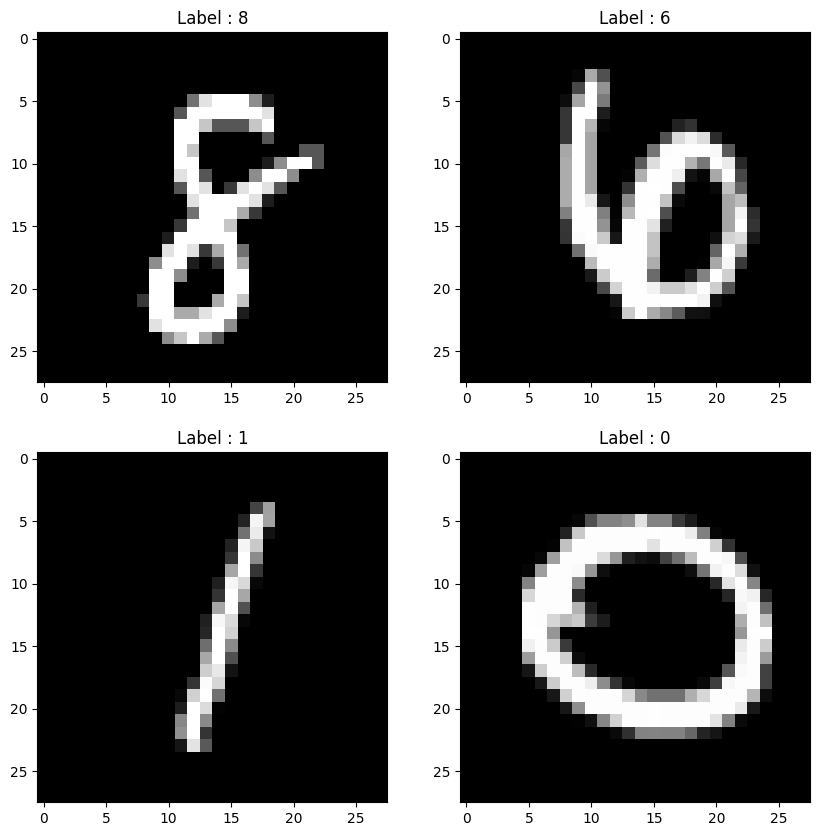

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

In [9]:
class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    # We perform a normalization step before we run the input through the Dense
    # layer.

    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)

    # The Forward-Forward algorithm is below. We first perform the Dense-layer
    # operation and then get a Mean Square value for all positive and negative
    # samples respectively.
    # The custom loss function finds the distance between the Mean-squared
    # result and the threshold value we set (a hyperparameter) that will define
    # whether the prediction is positive or negative in nature. Once the loss is
    # calculated, we get a mean across the entire batch combined and perform a
    # gradient calculation and optimization step. This does not technically
    # qualify as backpropagation since there is no gradient being
    # sent to any previous layer and is completely local in nature.

    def forward_forward(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )

In [11]:
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

In [12]:
model = FFNetwork(dims=[784, 500, 500])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 250
history = model.fit(train_dataset, epochs=epochs)

Epoch 1/250
Training layer 1 now : 
Training layer 2 now : 
Training layer 1 now : 
Training layer 2 now : 
1/1 [==============================] - 94s 94s/step - FinalLoss: 0.7271
Epoch 2/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.7086
Epoch 3/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6972
Epoch 4/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6755
Epoch 5/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6525
Epoch 6/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6311
Epoch 7/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6121
Epoch 8/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5955
Epoch 9/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5806
Epoch 10/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5674
Epoch 11/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.555